In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

## Dynamic processing

This notebooks analyzes the dynamic tests performed on the ADC.

First, read in the data.

In [4]:
data = pd.read_csv("sine_0.csv")

# Subtract start time.
start = data.t.values[0]
data.t -= start
# To ms.
data.t /= 1000000
# data.t.values[0]
data.head()

,t,vout,code,vout_meas,vref
0,0.0000,2.300000,512.0,2.300000,4.6
1,0.1958,3.651906,999.0,3.651906,4.6
2,0.3974,4.487430,1001.0,4.487430,4.6
3,0.5915,4.487430,814.0,4.487430,4.6
4,0.7553,3.651906,512.0,3.651906,4.6


In [41]:
def normalize(input_data):
    maximum = np.max(input_data)
    return np.float64(input_data / maximum)
    # return input_data / len(input_data)

def normalized_fourier(signal, sample_rate, signal_length):
    # transformed_signal = np.abs(np.fft.rfft(signal)) / np.max(signal)
    transformed_signal = np.abs(np.fft.rfft(signal)) / signal_length
    resolution = sample_rate / signal_length

    x = [x * resolution for x in range(len(transformed_signal))]

    return transformed_signal, x

def to_decibels(signal):
    ref = np.max(signal)
    output = 20 * np.log10(signal / ref)
    return output

In [123]:
def sine(n_samples: int, periods: float, min_value: float, max_value: float):
        x = np.linspace(0, 2 * np.pi * periods, n_samples, endpoint=False)
        # Create a sine wave and also map it to the specified range.
        return np.interp(np.sin(x), [-1, 1], [min_value, max_value])

def code_to_v(code, vref, res=1024):
        return code * vref / res

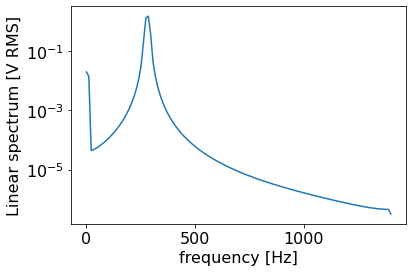

In [129]:
n_samples = 28000
fs = 2800
frequency = 280
periods = n_samples / fs * frequency
output_data = sine(n_samples, periods, 0, 4.6)

f, Pxx_spec = signal.welch(output_data, fs, scaling="spectrum")
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

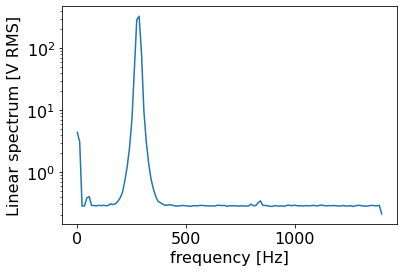

In [131]:
from scipy import signal

f, Pxx_spec = signal.welch(data.code, fs, scaling='spectrum')
# f, Pxx_spec = signal.welch(code_to_v(data.code, 4.6), fs, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

In [63]:
fft = np.abs(np.fft.rfft(data.code))

print(fft.argsort()[-2:])

signal_power = np.sum(fft[fft.argsort()[-2:]] ** 2)
print(signal_power)
noise_indices = list(range(len(fft)))
del noise_indices[0]
del noise_indices[2799]
print(len(noise_indices))
noise_power = np.sum(fft[noise_indices] ** 2)
print(noise_power)

snr = 20 * np.log10(signal_power / noise_power)
print(snr)

[   0 2800]
54833995580970.67
13999
8675872314.322504
76.01473481953896


Text(0, 0, 'SNR = ~76 dB')

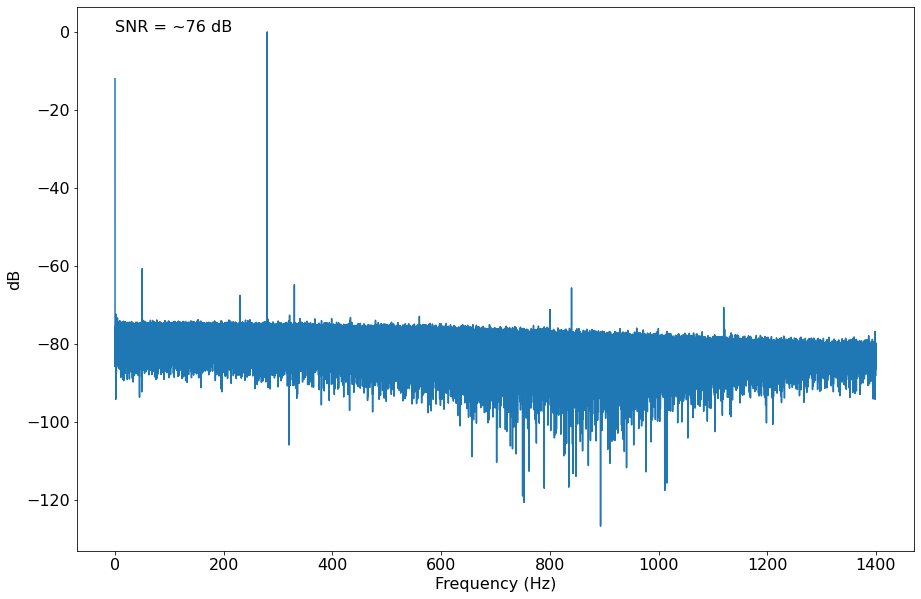

In [70]:
fft, x = normalized_fourier(data.code, 2800, 28000)
fft = to_decibels(fft)

plt.rc("font", size=16)
plt.figure(figsize=(15, 10))
plt.plot(x, fft)
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.text(0, 0, s="SNR = ~76 dB")

In [116]:
input_noise_data = pd.read_csv("input_noise_0.csv")

# Subtract start time.
start = input_noise_data.t.values[0]
input_noise_data.t -= start
# To ms.
input_noise_data.t /= 1000000
# data.t.values[0]
input_noise_data = input_noise_data[:9999]
input_noise_data.head()

,t,vout,code,vout_meas,vref
0,0.0000,2.5,558.0,2.5,4.6
1,0.3417,2.5,558.0,2.5,4.6
2,0.5607,2.5,557.0,2.5,4.6
3,0.7863,2.5,557.0,2.5,4.6
4,1.0016,2.5,558.0,2.5,4.6


In [112]:
plt.figure(figsize=(15, 5))
print(input_noise_data.code.mode())
input_noise_data.code -= 557


0    557.0
dtype: float64


<Figure size 1080x360 with 0 Axes>

(array([1.84018402e-02, 6.38763876e-01, 3.31933193e-01, 1.06010601e-02,
       3.00030003e-04]), array([555.5, 556.5, 557.5, 558.5, 559.5, 560.5]), <BarContainer object of 5 artists>)


Text(0, 0.5, 'Probability mass / density')

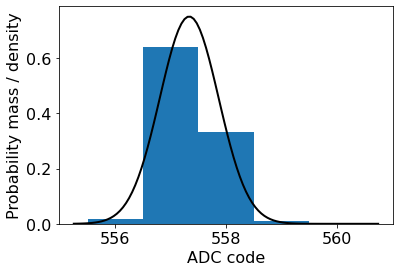

In [156]:
from scipy.stats import norm
mean, std_dev = norm.fit(input_noise_data.code.astype(int))

values = input_noise_data.code.astype(int)

bins = list(np.sort(values.unique()) - 0.5)
bins.append(np.max(bins) + 1)
real_hist = plt.hist(input_noise_data.code.astype(int), bins=bins, density=True)
print(real_hist)
# real_hist = plt.hist(input_noise_data.code.astype(int))

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)


plt.xlabel("ADC code")
plt.ylabel("Probability mass / density")

In [132]:
input_noise_data.code.value_counts()
# input_noise_data.code.argmin()

557.0    6387
558.0    3319
556.0     184
559.0     106
560.0       3
Name: code, dtype: int64